In [8]:
# Import statements. There are a lot of different packages that you can use. This is just some of them.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress, pearsonr
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Let's make a regression! 
I want to figure out what I should price NGLs given an oil price. We will use CLS. 

I also want to convert my findings to USD.

In [9]:
# Import pricing data from Sproule
oil = pd.read_excel("https://sproule.com/wp-content/uploads/2024/10/2024-09-Escalated.xlsx", sheet_name="North American Oil", header=7, usecols="R,V:AB")
ngl = pd.read_excel("https://sproule.com/wp-content/uploads/2024/10/2024-09-Escalated.xlsx", sheet_name="Natural Gas Liquids", header=7, usecols="R:AF")

# Average Annual CAD to USD exchange rate. We use a series, not a single number, since the exchange rate can change every year.
cad_usd = pd.DataFrame({'year':[2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],
                        'cad_usd':[0.77,  0.77, 0.75, 0.75, 0.80, 0.77, 0.74, 0.73]}) # Data taken from the Bank of Canada

In [10]:
# Clean the data. 
ngl_concat = ngl[['Year.1', 'Propane at Edmonton $/bbl.1', ' Condensate at Edmonton $/bbl.1', 'Butane at Edmonton $/bbl.1']] # Take only pricing at Edmonton
ngl_concat.columns = ['year','propane','condensate','butane'] # Rename for ease of use
oil_concat = oil[['Year.1', 'Canadian Light Sweet\n40 API\n$/Bbl.1']] # Repeat
oil_concat.columns = ['year','cls']

# Merge the dfs together
df = ngl_concat.merge(oil_concat, how='outer')
df = df.dropna(axis=0) # Drop NaN values. The OLS package doesn't know how to handle nulls.

In [11]:
# You will notice the years column is quite messy still. We need to clean it up more to convert it into a numeric.
df = df[df['year'] != "2024 3 mo. Est"] # We don't want the estimated part of 2024, just the actuals.
df['year'] = df['year'].astype(str).str.extract(r'(\d+)') # Remove non numerical values
df['year'] = pd.to_numeric(df['year']) # Convert to a numeric

df = df[(df['year'] > 2016) & ((df['year'] < 2025))] # Choose which years we want to include. We will include 2017 to 2024

# Convert to USD
df = df.merge(cad_usd, how='left') # Merge exchange rate df
df_usd = df.copy() # New df for USD values (currently in CAD)
for col in df_usd.columns:
    if col not in ['year','cad_usd']:
        df_usd[f'{col}'] = df_usd[f'{col}'] * df_usd['cad_usd'] # Multiply pricing series by respective exchange rate series
df_usd

,year,propane,condensate,butane,cls,cad_usd
0,2017,26.938493,62.992813,41.313173,57.970294,0.77
1,2018,24.885839,73.096116,31.016825,63.123048,0.77
2,2019,15.045319,62.592920,20.787005,60.385969,0.75
3,2020,14.030895,42.892719,18.815028,39.055653,0.75
4,2021,39.076831,77.351237,46.508339,72.331370,0.80
5,2022,42.007260,101.679990,51.711030,100.397305,0.77
6,2023,22.637925,78.661520,34.903803,76.419454,0.74
7,2024,21.213152,73.913435,33.537149,72.963189,0.73


In [12]:
# Run OLS
params = pd.DataFrame({'ngl':[], 'coefficient':[]}) # df to store coefficients
for col in df_usd.columns:
    if col not in ['year', 'cls_usd', 'cls', 'cad_usd']: # I don't want to regress these columns
        # Regress each ngl price against the Canada Light Sweet price
        formula = f'{col} ~ cls -1'
        OLS = ols(formula=formula, data=df_usd) 
        model = OLS.fit()
        
        # Store Coefficients
        coef = model.params.iloc[0] # Grab the coefficient at index 0
        temp = pd.DataFrame({'ngl':[col], 'coefficient':[coef]}) # Create a temporary df to overwrite for each iteration
        params = pd.concat([params, temp]) # Concat the temporary df with the permanent one.

# Display coefficients. This gives us multipliers to use to get NGL prices from CLS prices. 
params

,ngl,coefficient
0,propane,0.382404
0,condensate,1.049661
0,butane,0.513257


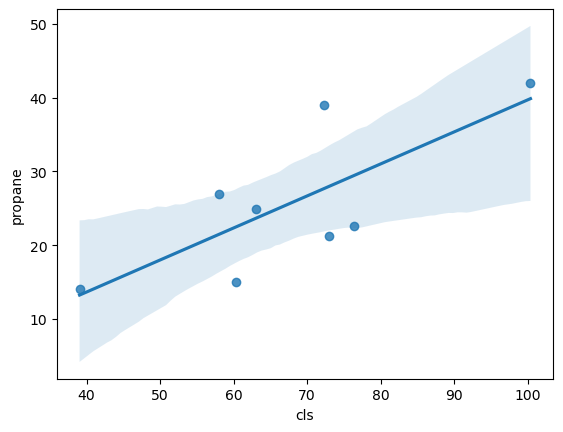

In [13]:
# Regplot can show us the regression line
sns.regplot(data=df_usd, x='cls', y='propane')
plt.show()

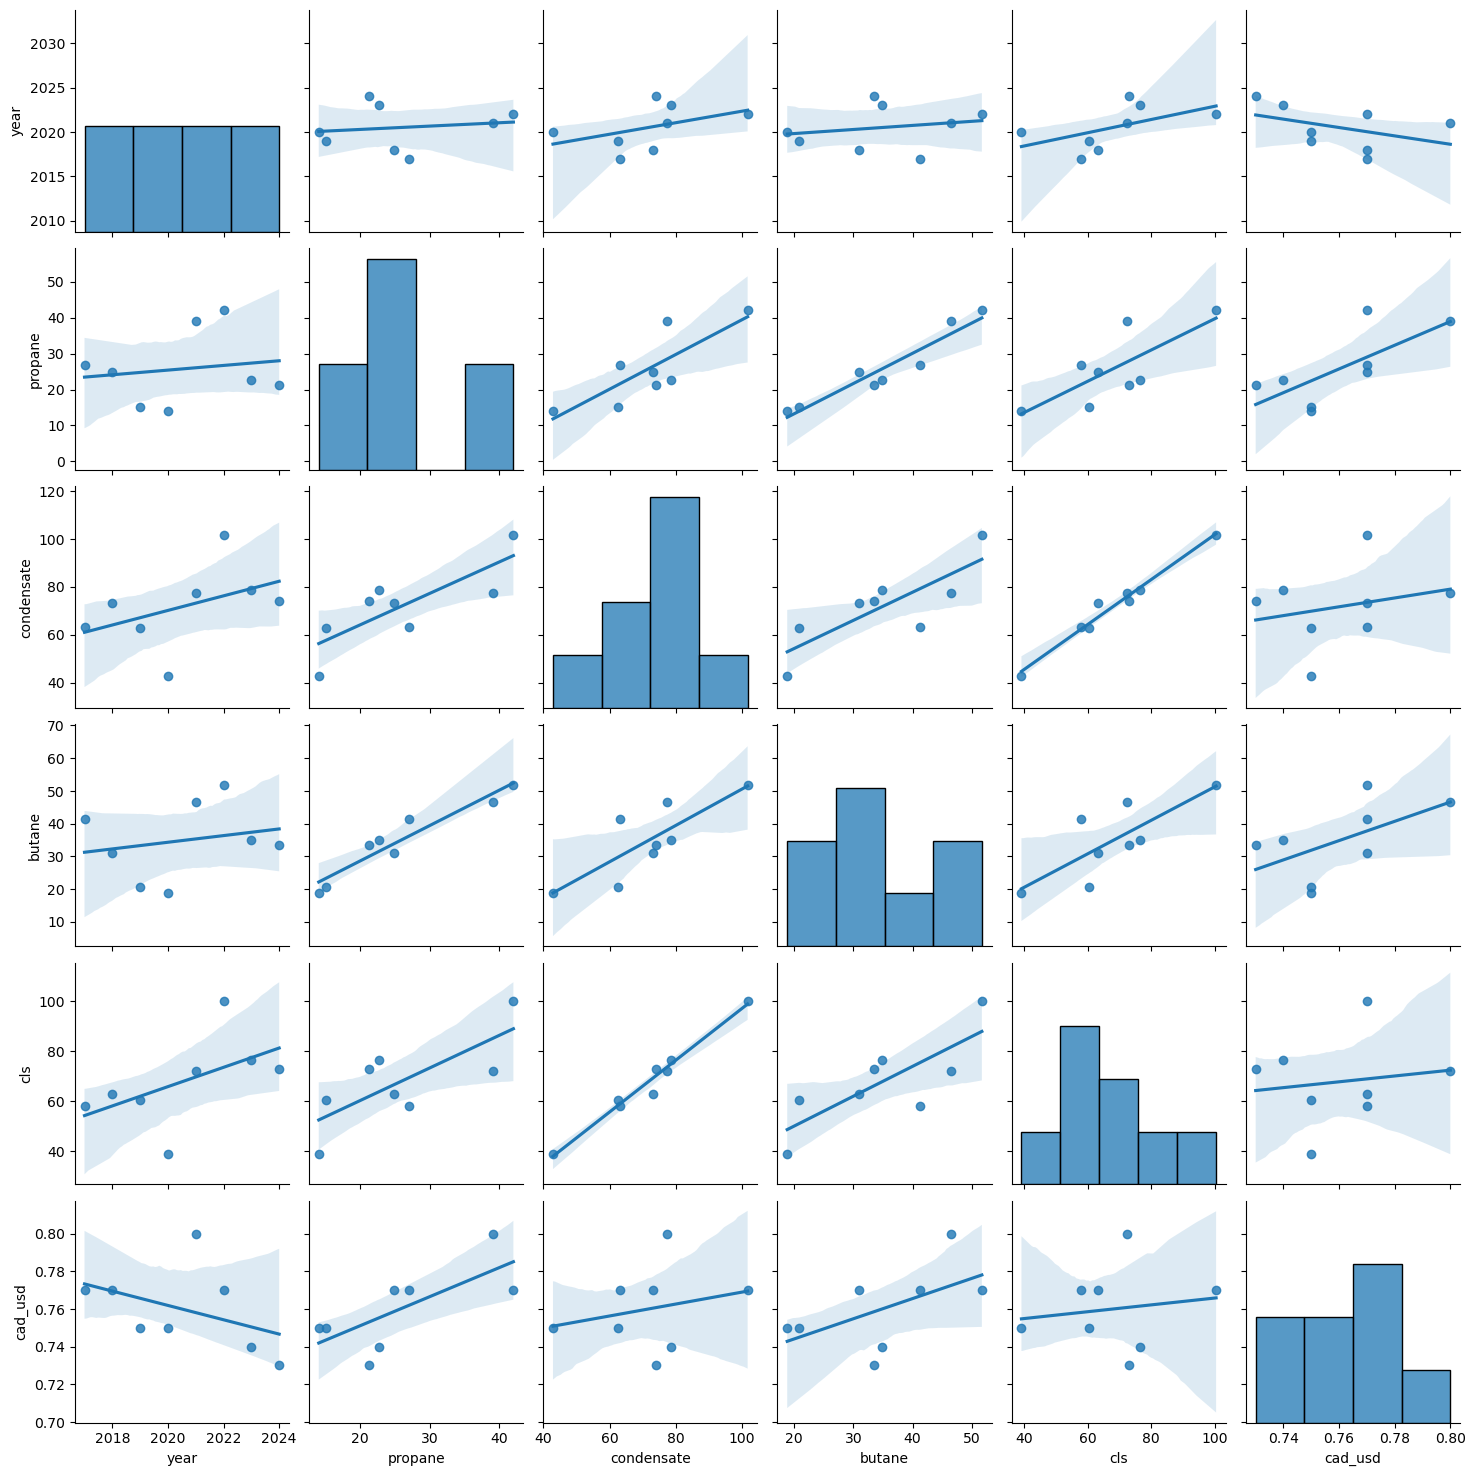

In [14]:
# Pairplot can show us multiple regression lines where different variables are assumed to be the dependent/independent
sns.pairplot(data=df_usd, kind='reg')
plt.show()